In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/')

In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 18.1 MB/s 


In [5]:
%cd HSI_classification/

/content/drive/My Drive/HSI_classification


In [6]:
##This is a pytorch implement for HybridSN 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import spectral
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from scipy.io import loadmat
import os
from tqdm.notebook import tqdm
%matplotlib inline

In [7]:
##hypeperameters and experimental settings
RANDOM_SEED=666
DATASET = 'IP'    ## PU  IP  SA  
train_ratio = 0.01  ## ratio of training data
val_ratio = 0.01    ## ratio of valuating data
EPOCH = 100    ##number of epoch
VAL_EPOCH = 5  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 16
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components
PATCH_SIZE = 25 
NUM_CLASS = 16
SAVE_PATH = './results/IN'

In [8]:
random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)
# torch.cuda.manual_seed(RANDOM_SEED)
# torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
def loadData(name):
    if name == 'IP':
        data = loadmat('./datasets/Indian_pines_corrected.mat')['indian_pines_corrected']
        labels = loadmat('./datasets/Indian_pines_gt.mat')['indian_pines_gt']
        class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture", 
                       "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats","Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat", "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    elif name == 'SA':
        data = loadmat('./datasets/Salinas_corrected.mat')['salinas_corrected']
        labels = loadmat('./datasets/Salinas_gt.mat')['salinas_gt']
        class_name = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth','Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green','Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
    elif name == 'PU':
        data = loadmat('./datasets/PaviaU.mat')['paviaU']
        labels = loadmat('./datasets/PaviaU_gt.mat')['paviaU_gt']
        class_name = ['Asphalt', 'Meadows', 'Gravel', 'Trees','Painted metal sheets', 'Bare Soil', 
                      'Bitumen','Self-Blocking Bricks', 'Shadows']
    return data, labels, class_name


In [10]:
data, label, class_name = loadData(DATASET)

In [11]:
data.shape, label.shape

((145, 145, 200), (145, 145))

In [12]:
# rgb_view=spectral.imshow(data,(30,20,10),classes=label,title='RGB origin',figsize=(7,7))
# gt_view = spectral.imshow(classes=label, title='GroundTruth',figsize=(7,7))
# view = spectral.imshow(data,(30,20,10),classes=label,figsize=(7,7))
# view.set_display_mode('overlay')
# view.class_alpha = 0.5
# view.set_title('Overlay')
# spectral.save_rgb(f'results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
# spectral.save_rgb(f'results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [13]:
def applyPCA(X, numComponents=15):
    """PCA processing

    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional): number of reserved components. Defaults to 15.

    Returns:
        newX: _description_
    """
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [14]:
data,pca = applyPCA(data,N_PCA)

In [15]:
data.shape, label.shape

((145, 145, 15), (145, 145))

In [16]:
y = label

In [17]:
# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 深度学习框架 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [18]:
all_data, all_label = createImageCubes(data, label, windowSize=PATCH_SIZE, removeZeroLabels = False)

In [19]:
data, label = createImageCubes(data, label, windowSize=PATCH_SIZE)

In [20]:
data.shape, label.shape, all_data.shape, all_label.shape

((10249, 25, 25, 15), (10249,), (21025, 25, 25, 15), (21025,))

In [21]:
def sampling(train_ratio, val_ratio, ground_truth):
    train = {}
    val = {}
    test = {}
    labels_loc = {}
    m = int(np.max(label))+1

    for i in range(m):
        indexes = [j for j, x in enumerate(ground_truth.ravel().tolist()) if x == i]
        np.random.shuffle(indexes)
        labels_loc[i] = indexes
        # if proportion != 1:
        #     nb_val = max(int((1 - proportion) * len(indexes)), 5)
        # else:
        #     nb_val = 0
        nb_train = max(int(train_ratio*len(indexes)) ,5)
        nb_val = max(int((val_ratio)*len(indexes)) ,2)
        train[i] = indexes[:nb_train]
        val[i] = indexes[nb_train:nb_train+nb_val]
        test[i] = indexes[nb_train+nb_val:]
    train_indexes = []
    val_indexes = []
    test_indexes = []
    for i in range(m):
        train_indexes += train[i]
        val_indexes += val[i]
        test_indexes += test[i]
    np.random.shuffle(train_indexes)
    np.random.shuffle(val_indexes)
    np.random.shuffle(test_indexes)
    return train_indexes, val_indexes, test_indexes

In [22]:
train_indexes, val_indexes, test_indexes = sampling(train_ratio, val_ratio, label)

In [23]:
len(train_indexes), len(val_indexes), len(test_indexes)

(124, 102, 10023)

In [24]:
Xtrain = data[train_indexes]
Xval = data[val_indexes]
Xtest = data[test_indexes]


ytrain = label[train_indexes]
yval = label[val_indexes]
ytest = label[test_indexes]

In [25]:
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[3],Xtrain.shape[1],Xtrain.shape[2])
Xval = Xval.reshape(Xval.shape[0],Xval.shape[3],Xval.shape[1],Xval.shape[2])
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[3],Xtest.shape[1],Xtest.shape[2])
all_data = all_data.reshape(all_data.shape[0],all_data.shape[3],all_data.shape[1], all_data.shape[2])

In [26]:
all_data.shape, Xtest.shape

((21025, 15, 25, 25), (10023, 15, 25, 25))

In [27]:
sample_report = f"{'class': ^10}{'train_num':^10}{'val_num':^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
#     if i == 0: continue
    sample_report += f"{i: ^10}{(ytrain==i).sum(): ^10}{(yval==i).sum(): ^10}{(ytest==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^10}{len(ytrain): ^10}{len(yval): ^10}{len(ytest): ^10}{len(label): ^10}"
print(sample_report)

  class   train_num  val_num   test_num   total   
   0.0        5         2         39        46    
   1.0        14        14       1400      1428   
   2.0        8         8        814       830    
   3.0        5         2        230       237    
   4.0        5         4        474       483    
   5.0        7         7        716       730    
   6.0        5         2         21        28    
   7.0        5         4        469       478    
   8.0        5         2         13        20    
   9.0        9         9        954       972    
   10.0       24        24       2407      2455   
   11.0       5         5        583       593    
   12.0       5         2        198       205    
   13.0       12        12       1241      1265   
   14.0       5         3        378       386    
   15.0       5         2         86        93    
  total      124       102      10023     10249   


In [28]:
Xtrain.shape,Xval.shape,Xtest.shape,all_data.shape

((124, 15, 25, 25),
 (102, 15, 25, 25),
 (10023, 15, 25, 25),
 (21025, 15, 25, 25))

In [29]:

""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len


""" Validating dataset"""
class ValDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xval.shape[0]
        self.x_data = torch.FloatTensor(Xval)
        self.y_data = torch.LongTensor(yval)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

class DS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = all_data.shape[0]
        self.x_data = torch.FloatTensor(all_data)
        self.y_data = torch.LongTensor(all_label)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

In [30]:
all_data.shape, all_label.shape

((21025, 15, 25, 25), (21025,))

In [31]:
trainset = TrainDS()
valset = ValDS()
testset  = TestDS()
dataset = DS()   #全体数据，包含背景类

In [32]:
len(dataset)

21025

In [33]:
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
data_loader = torch.utils.data.DataLoader(dataset=dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [34]:
## Defination of HybridSN
class HybridSN(nn.Module):
    def __init__(self, in_chs, patch_size, class_nums):
        super().__init__()
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.conv1 = nn.Sequential(
                    nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
                    nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
                    nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                    nn.ReLU(inplace=True))
        
        self.x1_shape = self.get_shape_after_3dconv()
        # print(self.x1_shape)
        self.conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=self.x1_shape[1]*self.x1_shape[2],out_channels=64,kernel_size=(3, 3)),
                    nn.ReLU(inplace=True))
        self.x2_shape = self.get_shape_after_2dconv()
        # print(self.x2_shape)
        self.dense1 = nn.Sequential(
                    nn.Linear(self.x2_shape,256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense2 = nn.Sequential(
                    nn.Linear(256,128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense3 = nn.Sequential(
                    nn.Linear(128,class_nums)
                   )
    
    def get_shape_after_2dconv(self):
        x = torch.zeros((1, self.x1_shape[1]*self.x1_shape[2], self.x1_shape[3], self.x1_shape[4]))
        with torch.no_grad():
            x = self.conv4(x)
            print
        return x.shape[1]*x.shape[2]*x.shape[3]
    
    def get_shape_after_3dconv(self):
        x = torch.zeros((1, 1, self.in_chs, self.patch_size, self.patch_size))
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.shape
    
    def forward(self, X):
        X = X.unsqueeze(1)
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2],x.shape[3],x.shape[4])
        # print(x.shape)
        x = self.conv4(x)
        x = x.contiguous().view(x.shape[0], -1)
        # print(x.shape)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.dense3(x)
        return out

net = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
# summary(net, input_size=(1,N_PCA,PATCH_SIZE,PATCH_SIZE),col_names=['num_params','kernel_size','mult_adds','input_size','output_size'],col_width=10,row_settings=['var_names'],depth=4)

In [35]:
## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []




In [36]:
model = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
model.to(device)

HybridSN(
  (conv1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(7, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(5, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (dense1): Sequential(
    (0): Linear(in_features=18496, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
  )
  (dense2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
  )
  (dense3): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
  )
)

Training::   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0/100 loss:0.1793246692226779  acc:0.0967741935483871


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 1/100 loss:0.1744832492643787  acc:0.1935483870967742


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 2/100 loss:0.17345241000575404  acc:0.16129032258064516


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 3/100 loss:0.16930208475359024  acc:0.20161290322580644


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 4/100 loss:0.16496788301775533  acc:0.21774193548387097


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 4/100  val_acc:0.23529411764705882


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 5/100 loss:0.16807916664308117  acc:0.21774193548387097


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 6/100 loss:0.16322144577580114  acc:0.23387096774193547


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 7/100 loss:0.1390460556553256  acc:0.29838709677419356


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 8/100 loss:0.12298267502938548  acc:0.41935483870967744


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 9/100 loss:0.110959384710558  acc:0.43548387096774194


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 9/100  val_acc:0.5196078431372549


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 10/100 loss:0.09591698934954981  acc:0.5806451612903226


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 11/100 loss:0.08227556078664718  acc:0.6048387096774194


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 12/100 loss:0.07060446710355821  acc:0.6774193548387096


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 13/100 loss:0.06202659010887146  acc:0.6290322580645161


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 14/100 loss:0.048700389362150626  acc:0.7580645161290323


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 14/100  val_acc:0.6764705882352942


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 15/100 loss:0.042901814704941164  acc:0.8145161290322581


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 16/100 loss:0.04609311540280619  acc:0.8225806451612904


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 17/100 loss:0.045217527256857966  acc:0.8145161290322581


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 18/100 loss:0.02870242790349068  acc:0.9032258064516129


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 19/100 loss:0.022454856985038327  acc:0.8790322580645161


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 19/100  val_acc:0.6372549019607843


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 20/100 loss:0.023920129533977277  acc:0.8870967741935484


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 21/100 loss:0.019746565710633032  acc:0.9193548387096774


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 22/100 loss:0.018663967448857524  acc:0.9354838709677419


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 23/100 loss:0.01243021946039892  acc:0.9435483870967742


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 24/100 loss:0.008686896218287369  acc:0.967741935483871


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 24/100  val_acc:0.6862745098039216


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 25/100 loss:0.009520478696832734  acc:0.9596774193548387


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 26/100 loss:0.00925278038747849  acc:0.967741935483871


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 27/100 loss:0.008621516757674755  acc:0.9596774193548387


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 28/100 loss:0.024637662655403538  acc:0.8709677419354839


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 29/100 loss:0.01512860491751663  acc:0.8870967741935484


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 29/100  val_acc:0.6862745098039216


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 30/100 loss:0.015103778403793131  acc:0.9516129032258065


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 31/100 loss:0.013394938511473517  acc:0.9435483870967742


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 32/100 loss:0.012422197888935766  acc:0.9435483870967742


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 33/100 loss:0.00972604472565675  acc:0.9596774193548387


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 34/100 loss:0.010497387228233198  acc:0.9516129032258065


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 34/100  val_acc:0.6764705882352942


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 35/100 loss:0.006638325870998444  acc:0.9758064516129032


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 36/100 loss:0.00854919074223407  acc:0.9435483870967742


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 37/100 loss:0.014683124684398212  acc:0.9435483870967742


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 38/100 loss:0.013138071815070186  acc:0.9274193548387096


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 39/100 loss:0.0094039652256235  acc:0.967741935483871


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 39/100  val_acc:0.6862745098039216


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 40/100 loss:0.00645939166086816  acc:0.9758064516129032


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 41/100 loss:0.012632182331740736  acc:0.9596774193548387


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 42/100 loss:0.004845354893815613  acc:0.9596774193548387


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 43/100 loss:0.0035655072049027487  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 44/100 loss:0.0027342652488920476  acc:0.9919354838709677


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 44/100  val_acc:0.6666666666666666


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 45/100 loss:0.003940304553496742  acc:0.9758064516129032


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 46/100 loss:0.0025573092383227402  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 47/100 loss:0.004826115682766202  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 48/100 loss:0.0005411151866771815  acc:1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 49/100 loss:0.001794159999506871  acc:0.9919354838709677


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 49/100  val_acc:0.7156862745098039


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 50/100 loss:0.0003880796690693035  acc:1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 51/100 loss:0.0009381697348053128  acc:1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 52/100 loss:0.001885368058743376  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 53/100 loss:0.0012847481607863183  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 54/100 loss:0.009000248922318625  acc:0.9838709677419355


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 54/100  val_acc:0.696078431372549


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 55/100 loss:0.0028267256434886686  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 56/100 loss:0.006960871368421302  acc:0.9596774193548387


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 57/100 loss:0.005687994571710606  acc:0.9758064516129032


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 58/100 loss:0.0038380308177429177  acc:0.9758064516129032


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 59/100 loss:0.004411381702201681  acc:0.9838709677419355


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 59/100  val_acc:0.7058823529411765


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 60/100 loss:0.004795753619550998  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 61/100 loss:0.0022452086615826813  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 62/100 loss:0.0033820711832959205  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 63/100 loss:0.0008584460396718896  acc:1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 64/100 loss:0.0017900217259715823  acc:0.9919354838709677


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 64/100  val_acc:0.7058823529411765


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 65/100 loss:0.00016597105610755182  acc:1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 66/100 loss:0.003033547568197865  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 67/100 loss:0.0007533047867934417  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 68/100 loss:0.0013174681193150158  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 69/100 loss:0.00016501072244160065  acc:1.0


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 69/100  val_acc:0.696078431372549


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 70/100 loss:0.0011173854868209146  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 71/100 loss:0.0025249827612565095  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 72/100 loss:0.007198859812154795  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 73/100 loss:0.00410959620480313  acc:0.9758064516129032


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 74/100 loss:0.0038865305621349705  acc:0.9758064516129032


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 74/100  val_acc:0.7058823529411765


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 75/100 loss:0.0025206083791413075  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 76/100 loss:0.0029016203076143057  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 77/100 loss:0.0016854382420499478  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 78/100 loss:0.0011475658881658268  acc:0.9919354838709677


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 79/100 loss:0.004684428566472507  acc:0.9758064516129032


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 79/100  val_acc:0.7058823529411765


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 80/100 loss:0.002875711644000764  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 81/100 loss:0.004192010364814421  acc:0.9758064516129032


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 82/100 loss:0.0013366806642312117  acc:1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 83/100 loss:0.001609114379994759  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 84/100 loss:0.0014529817966714262  acc:0.9919354838709677


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 84/100  val_acc:0.7058823529411765


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 85/100 loss:0.0017756885762273374  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 86/100 loss:0.007279641531575239  acc:0.967741935483871


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 87/100 loss:0.0031939194389363572  acc:0.9758064516129032


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 88/100 loss:0.007435094529712167  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 89/100 loss:0.0017685008896214346  acc:1.0


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 89/100  val_acc:0.7156862745098039


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 90/100 loss:0.0026851823758108602  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 91/100 loss:0.0053929072180894325  acc:0.967741935483871


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 92/100 loss:0.00110708338037981  acc:1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 93/100 loss:0.0008526500337944937  acc:1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 94/100 loss:0.0009857129595231176  acc:1.0


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 94/100  val_acc:0.696078431372549


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 95/100 loss:0.0017159693276381962  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 96/100 loss:0.0048122446650737515  acc:0.9758064516129032


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 97/100 loss:0.009727730755619104  acc:0.9516129032258065


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 98/100 loss:0.0068807348143309355  acc:0.9838709677419355


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 99/100 loss:0.004641155924482812  acc:0.967741935483871


  0%|          | 0/7 [00:00<?, ?it/s]

epoch 99/100  val_acc:0.7156862745098039
Stop in epoch 99


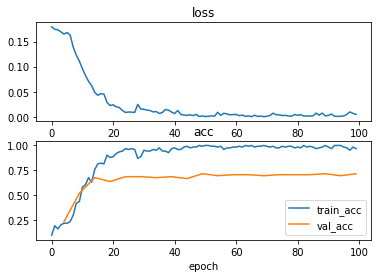

In [37]:

optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            # target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        # valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                # target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(),save_name)
    ax1.plot(np.arange(e+1),loss_list)
    ax1.set_title('loss')
    ax1.set_xlabel('epoch')
    ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
    ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
    ax2.set_title('acc')
    ax2.set_xlabel('epoch')
    ax2.legend()
except Exception as exc:
    print(exc)
finally: 
    print(f'Stop in epoch {e}')

In [38]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list

    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir

    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

In [39]:
all_label.shape

(21025,)

best model:epoch_99_acc_0.7157.pth


0it [00:00, ?it/s]

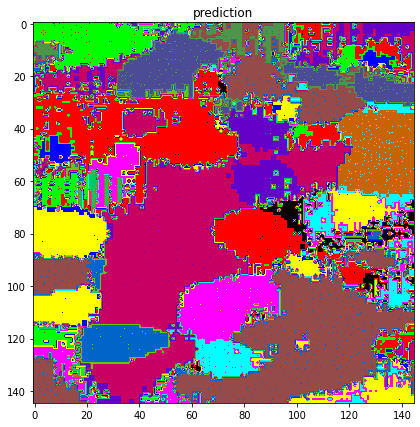

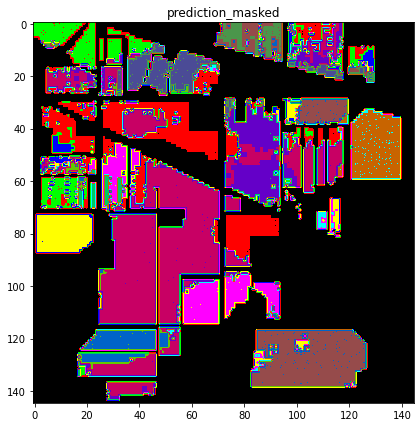

In [40]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH)
best_model = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path))
## inference
best_model.to(device)
best_model.eval()
pred_map = []
# for batch_idx, (data, _) in tqdm(enumerate(data_loader),total=len(data_loader)):
for batch_idx, (data, _) in tqdm(enumerate(data_loader)):

    pred = best_model(data.to(device))

    _, pred = torch.max(pred, dim = 1)
    # print(np.array(pred.detach().cpu()))
    pred_map += [np.array(pred.detach().cpu())]   # class 0 in pred_map is class 1 in gt
    # print(len(pred_map))
    # print(batch_idx)

pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(y.shape[0],y.shape[1])
spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
spectral.imshow(classes=pred_map*(y!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(y!=0),colors = spectral.spy_colors)

In [41]:
## classfication report
test_pred = pred_map[y!=0]+1
test_true = y[y!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
# fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
# fp.writelines(report_log)
# fp.close()

OA: 0.6579178456434774
AA: 0.6949208224760485
Kappa: 0.6065756371903489
                              precision    recall  f1-score   support

                     Alfalfa     0.7174    0.7174    0.7174        46
                 Corn-notill     0.5305    0.5546    0.5423      1428
                Corn-mintill     0.5964    0.4843    0.5346       830
                        Corn     0.3274    0.2321    0.2716       237
               Grass-pasture     0.7275    0.7184    0.7229       483
                 Grass-trees     0.8859    0.7658    0.8215       730
         Grass-pasture-mowed     0.2784    0.9643    0.4320        28
               Hay-windrowed     0.9389    0.9958    0.9665       478
                        Oats     0.2105    1.0000    0.3478        20
              Soybean-notill     0.7349    0.4393    0.5499       972
             Soybean-mintill     0.6283    0.8130    0.7088      2455
               Soybean-clean     0.6122    0.1012    0.1737       593
                 